In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

light_on = 0
PMT_num = 1107
testing = 0
voltage_use = [1400, 1500, 1600, 1700, 1800, 1900]
bins_lighton = 100
bins_dark = 50
range_lighton = 12000
range_dark = 600

In [2]:
data = []
if light_on:
    for i in voltage_use:
        file_path = '/raid13/genli/Coherent/PMT_Testing/Testing_%d/PMT%d_lighton_%d.dat' % (PMT_num, PMT_num, i)
        print(file_path)
        data.append(np.fromfile(file_path, dtype=np.int16))
else:
    for i in voltage_use:
        file_path = '/raid13/genli/Coherent/PMT_Testing/Testing_%d/PMT%d_dark_%d.dat' % (PMT_num, PMT_num, i)
        print(file_path)
        data.append(np.fromfile(file_path, dtype=np.int16))
    
#cut the 10 percent of start and end of the data
for i in range(len(data)):
    data[i] = data[i][int(len(data[i])*0.1):int(len(data[i])*0.9)]


#if testing, only use the first 30% data points
if testing:
    for i in range(len(data)):
        data[i] = data[i][:int(len(data[i])*0.3)]

/raid13/genli/Coherent/PMT_Testing/Testing_1107/PMT1107_dark_1400.dat


/raid13/genli/Coherent/PMT_Testing/Testing_1107/PMT1107_dark_1500.dat
/raid13/genli/Coherent/PMT_Testing/Testing_1107/PMT1107_dark_1600.dat
/raid13/genli/Coherent/PMT_Testing/Testing_1107/PMT1107_dark_1700.dat
/raid13/genli/Coherent/PMT_Testing/Testing_1107/PMT1107_dark_1800.dat
/raid13/genli/Coherent/PMT_Testing/Testing_1107/PMT1107_dark_1900.dat


<Figure size 1440x1152 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'ADC counts')

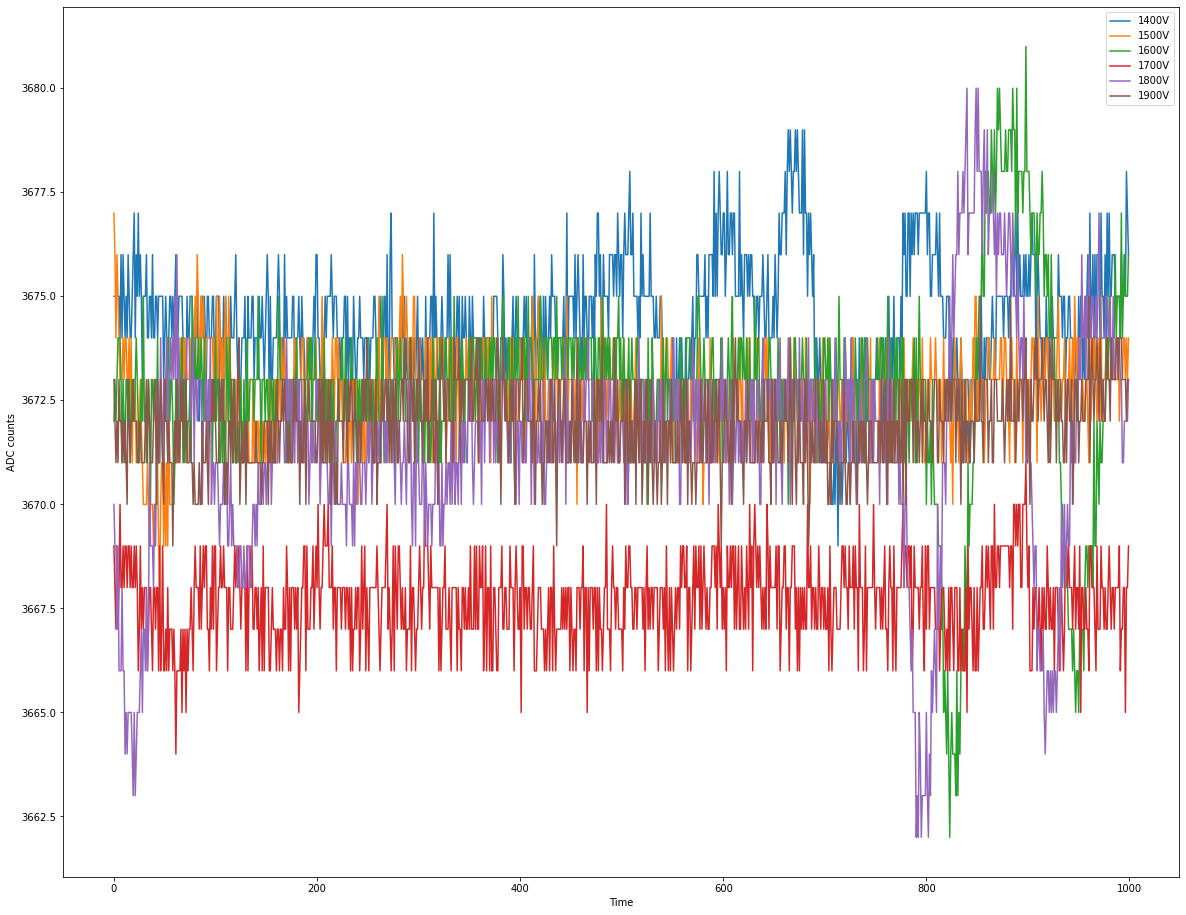

In [3]:
plt.figure(figsize=(20, 16))
for i in range(len(data)):
    plt.plot(data[i][0:1000], label='{}V'.format(voltage_use[i]))
plt.legend()
plt.xlabel('Time')
plt.ylabel('ADC counts')

In [4]:
def get_baseline(data):
    #get median of first 10000 samples
    baseline = np.median(data[0:10000])
    return baseline

def flip_data(data):
    # flip data
    baseline = get_baseline(data)
    data = baseline - data
    return data

In [5]:
for i in range(len(data)):
    data[i] = flip_data(data[i])

<Figure size 1440x1152 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'ADC counts')

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([-10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,  10. ,
         12.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'PMT1107 dark')

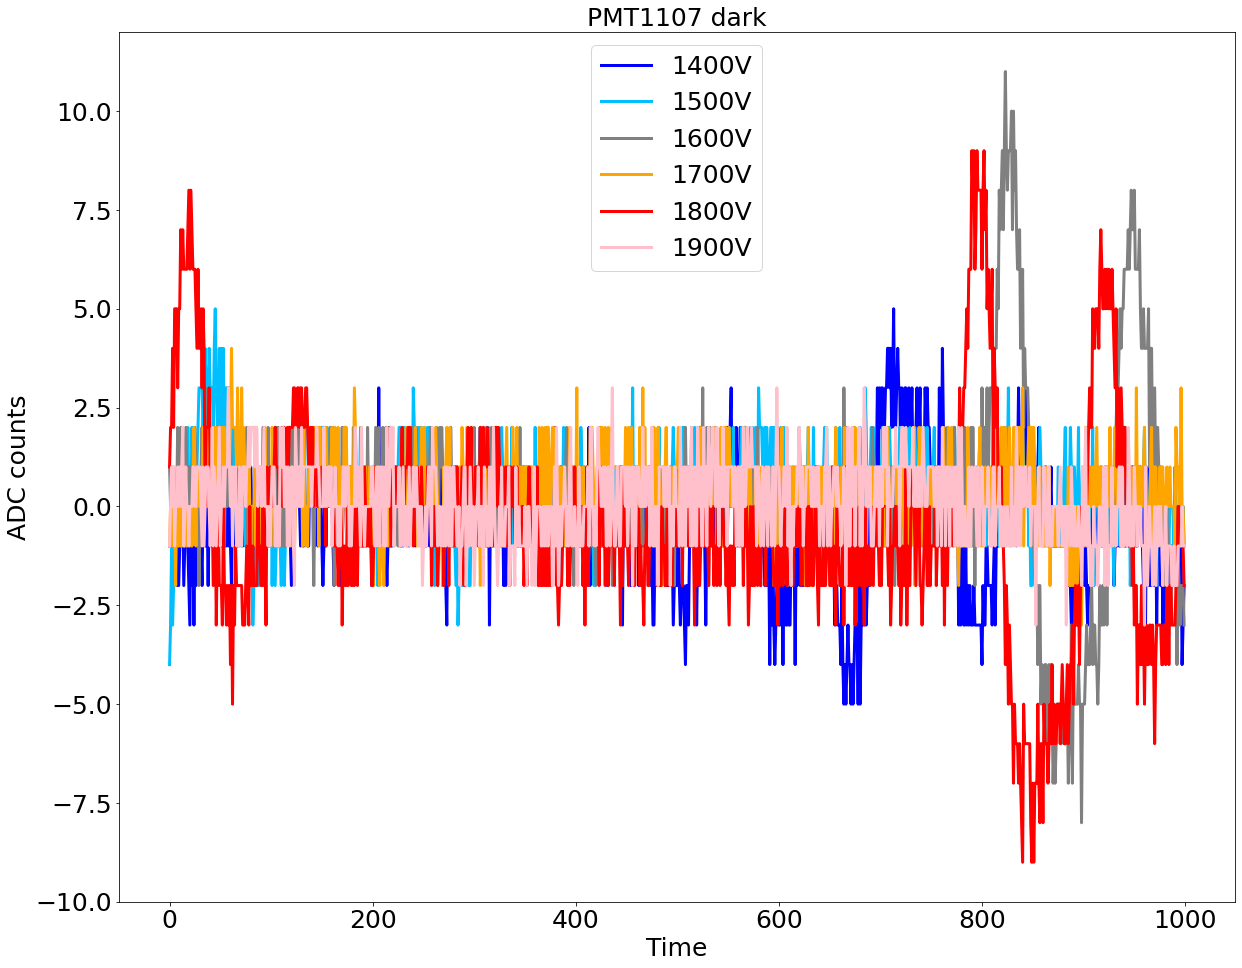

In [6]:
plt.figure(figsize=(20, 16))
colors = ['blue', 'deepskyblue', 'gray', 'orange', 'red', 'pink', 'green']
for i in range(len(data)):
    plt.plot(data[i][0:1000], label='{}V'.format(voltage_use[i]), linewidth=3, color=colors[i])
    
plt.legend(fontsize=25)
plt.xlabel('Time', fontsize=25)
plt.ylabel('ADC counts', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
if light_on:
    plt.title('PMT%d light on'%PMT_num, fontsize=25)
else:
    plt.title('PMT%d dark'%PMT_num, fontsize=25)

#save figure
if light_on:
    plt.savefig('PMT%d_lighton.png'%PMT_num)
else:
    plt.savefig('PMT%d_dark.png'%PMT_num)

In [7]:
#function to find peaks and integrate peaks
def find_peaks_lighton(data):
    # find the threshold
    threshold = np.median(np.sort(data[0:int(len(data)*0.2)])[-int(len(data)*0.0002):])
    print('Threshold = ', threshold)
    # find peaks above threshold and higher than the previous and next data points
    peaks = np.where((data > threshold) & (data >= np.roll(data, 1)) & (data >= np.roll(data, -1)) & (data >= np.roll(data, 2)) & (data >= np.roll(data, -2)) & (data >= np.roll(data, 3)) & (data >= np.roll(data, -3)) & (data >= np.roll(data, 4)) & (data >= np.roll(data, -4))& (data >= np.roll(data, 5)) & (data >= np.roll(data, -5)))[0]
    #distance between peaks should be larger than 100
    peaks = peaks[np.where(np.diff(peaks) > 100)[0]]
    # find the start and the end of the peaks
    threshold_width = 0.10*data[peaks]
    start = np.zeros(len(peaks), dtype=int)
    end = np.zeros(len(peaks), dtype=int)
    for i in range(len(peaks)):
        start_t = peaks[i]
        end_t = peaks[i]
        while data[start_t] > threshold_width[i]:
            start_t -= 1
        start[i] = start_t
        while data[end_t] > threshold_width[i]:
            end_t += 1
        end[i] = end_t
    # find the peak height
    height = data[peaks]
    # find the peak width
    width = end - start
    # find the peak area
    area = np.zeros(len(start))
    for i in range(len(start)):
        area[i] = np.sum(data[start[i]:end[i]])
    return peaks, start, end, height, width, area

def find_peaks_dark(data):
    # the threshold is related to the mean of top 0.0007% of the data
    threshold = np.median(np.sort(data[0:int(len(data)*0.2)])[-int(len(data)*0.000007):])
    print(len(data)*0.000005)
    length = len(data)
    print('Threshold = ', threshold)
    # find peaks above threshold and higher than the previous and next data points
    peaks = np.where((data > threshold) & (data >= np.roll(data, 1)) & (data >= np.roll(data, -1)) & (data >= np.roll(data, 2)) & (data >= np.roll(data, -2)) & (data >= np.roll(data, 3)) & (data >= np.roll(data, -3)))[0]
    #distance between peaks should be larger than 100
    peaks = peaks[np.where(np.diff(peaks) > 100)[0]]
    # find the start and the end of the peaks
    threshold_width = 0.20*data[peaks]
    start = np.zeros(len(peaks), dtype=int)
    end = np.zeros(len(peaks), dtype=int)
   
    #calculate the area of the peaks
    for i in range(len(peaks)):
        start_t = peaks[i]
        end_t = peaks[i]
        while data[start_t] > threshold_width[i]:
            if (start_t == 0):
                break
            else:
                start_t -= 1
        start[i] = start_t
        while data[end_t] > threshold_width[i]:
            if (end_t == length-1):
                break
            else:
                end_t += 1
        end[i] = end_t 
    #only use peaks with width larger than 0 and smaller than 1000
    shortest = 0
    longest = 1000
    peaks_new = peaks[np.where((end - start > shortest) & (end - start < longest))]
    start_new = start[np.where((end - start > shortest) & (end - start < longest))]
    end_new = end[np.where((end - start > shortest) & (end - start < longest))]
    # find the peak height
    height = data[peaks_new]
    # find the peak width
    width = end_new - start_new
    # find the peak area
    area = np.zeros(len(start_new))
    for i in range(len(start_new)):
        area[i] = np.sum(data[start_new[i]:end_new[i]])
    return peaks_new, start_new, end_new, height, width, area


def find_peak_fix_width(data):
    # find the threshold
    threshold = 30
    length = len(data)
    print('Threshold = ', threshold)
     # find peaks above threshold and higher than the previous and next data points
    peaks = np.where((data > threshold) & (data >= np.roll(data, 1)) & (data >= np.roll(data, -1)))[0]
    # peaks = np.where((data > threshold)& (data >= np.roll(data, 1)) & (data >= np.roll(data, -1)) & (data >= np.roll(data, 2)) & (data >= np.roll(data, -2)) & (data >= np.roll(data, 3)) & (data >= np.roll(data, -3)))[0]
    # find the start and the end of the peaks
    start = np.zeros(len(peaks), dtype=int)
    end = np.zeros(len(peaks), dtype=int)
    pre_peak = 5
    post_peak = 10
    for i in range(len(peaks)):
        start_t = peaks[i]
        end_t = peaks[i]
        if (start_t - pre_peak < 0):
            start_t = 0
        else:
            start_t -= pre_peak
        if (end_t + post_peak > length-1):
            end_t = length-1
        else:
            end_t += post_peak

        start[i] = start_t
        end[i] = end_t
    # find the peak height
    height = data[peaks]
    # find the peak width
    width = end - start
    # find the peak area
    area = np.zeros(len(start))
    for i in range(len(start)):
        area[i] = np.sum(data[start[i]:end[i]])
    return peaks, start, end, height, width, area

In [8]:
peaks = []
start = []
end = []
height = []
width = []
area = []
for i in range(len(data)):
    if light_on:
        numbers = find_peaks_lighton(data[i])
    
    else:
        numbers = find_peaks_dark(data[i])

    peaks.append(numbers[0])
    start.append(numbers[1])
    end.append(numbers[2])
    height.append(numbers[3])
    width.append(numbers[4])
    area.append(numbers[5])

    print('Number of peaks for {}V: {}'.format(voltage_use[i], len(peaks[i])))
    print('Peak height for {}V: {}'.format(voltage_use[i], height[i]))
    print('Peak width for {}V: {}'.format(voltage_use[i], width[i]))
    print('Peak area for {}V: {}'.format(voltage_use[i], area[i]))
    

#write the peaks' area to a txt file
if light_on:
    for i in range(len(data)):
        np.savetxt('PMT%d_lighton_%d_peaks_area.txt'%(PMT_num, voltage_use[i]), area[i])
else:
    for i in range(len(data)):
        np.savetxt('PMT%d_dark_%d_peaks_area.txt'%(PMT_num, voltage_use[i]), area[i])


343.596
Threshold =  11.0
Number of peaks for 1400V: 226
Peak height for 1400V: [ 12.  12.  12.  12.  12.  12.  12.  17.  32.  12.  12.  13.  12.  12.
  12.  16.  13.  12.  12. 106.  22.  12.  16.  12.  12.  14.  12.  12.
  12.  17.  14.  12.  13. 115.  12.  13.  12.  17.  12.  14.  12.  12.
  12.  12.  12.  12.  12.  12.  17.  13.  15.  12.  12.  12.  16.  16.
  12.  12.  16.  12.  15.  12.  12.  12.  12.  12.  12.  15.  39.  12.
  13.  14.  12.  13.  12.  12.  12.  12.  12.  13.  13.  21.  12.  64.
  12.  12.  14.  18.  12.  12.  12.  12.  12.  14.  12.  12.  19.  14.
  13.  14.  34.  13.  15.  12.  12.  12.  12.  15.  31.  16.  13.  13.
  15.  12.  15.  15.  14.  13.  12.  14.  12.  12.  13.  12.  12.  12.
  12.  13.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.
  13.  12.  13.  12.  12.  13.  12.  12.  12.  13.  16.  12.  12.  15.
  12.  18.  12.  12.  12.  12.  24.  12.  13.  12.  12.  12.  12.  13.
  12.  12.  20.  12.  14.  12.  14.  13.  19.  12.  15.  12.  12.  1

<Figure size 1440x1152 with 0 Axes>

(array([[0.00e+00, 1.40e+01, 2.66e+02, 8.60e+01, 9.00e+00, 5.00e+00,
         7.00e+00, 2.00e+00, 2.00e+00, 1.00e+00, 2.00e+00, 3.00e+00,
         1.00e+00, 2.00e+00, 1.00e+00, 3.00e+00, 1.00e+01, 1.80e+01,
         5.10e+01, 1.52e+02, 2.99e+02, 2.81e+02, 1.68e+02, 4.00e+01,
         9.00e+00, 2.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 1.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00],
        [0.00e+00, 2.70e+01, 6.89e+02, 1.12e+03, 4.40e+02, 9.00e+01,
         1.80e+01, 1.20e+01, 5.00e+00, 8.00e+00, 6.00e+00, 2.00e+00,
         4.00e+00, 4.00e+00, 5.00e+00, 8.00e+00, 1.10e+01, 8.00e+00,
         7.00e+00, 1.10e+01, 1.00e+01, 1.20e+01, 8.00e+00, 2.00e+00,
         1.00e+00, 3.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
    

Text(0.5, 0, 'Peak area')

Text(0, 0.5, 'Counts')

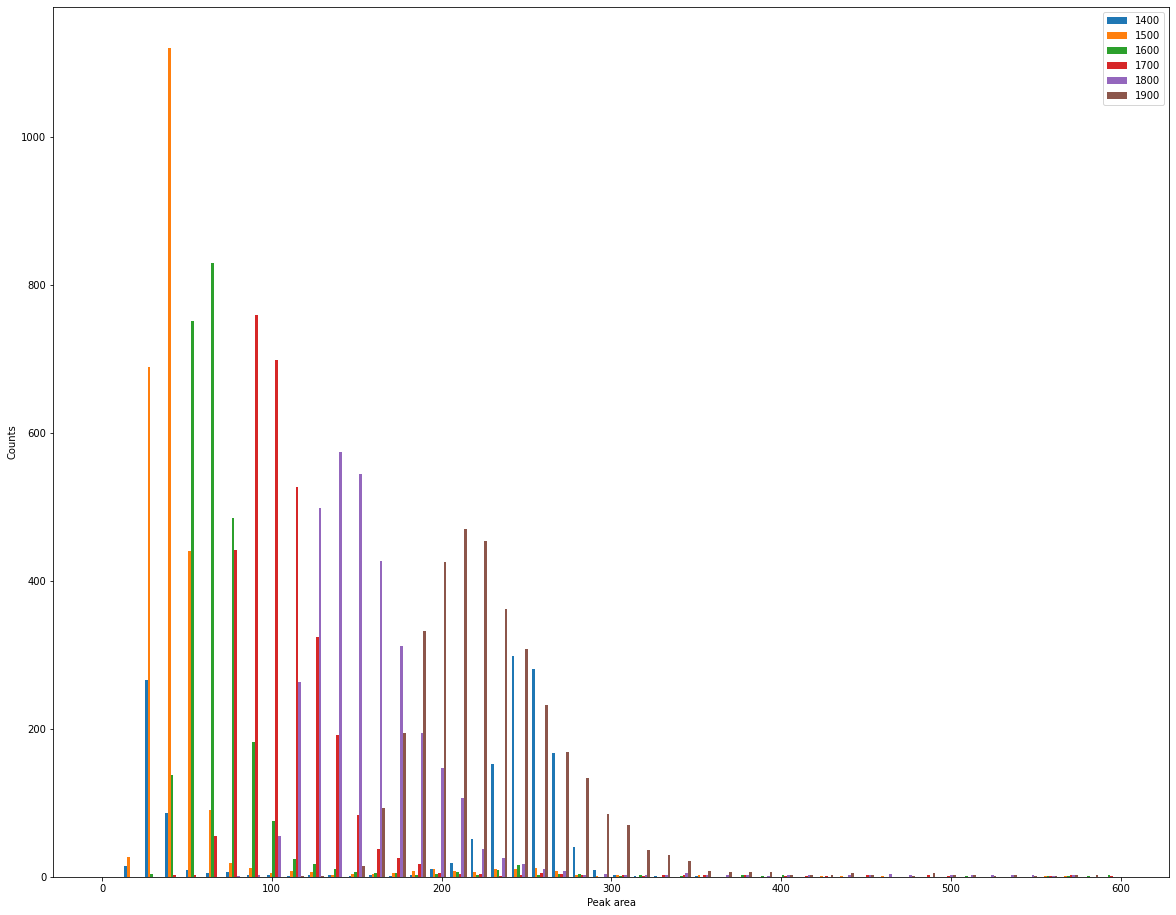

In [2]:
#read the peaks' area from txt files
area = []
for i in range(len(voltage_use)):
    if light_on:
        area.append(np.loadtxt('PMT%d_lighton_%d_peaks_area.txt'%(PMT_num, voltage_use[i])))
    else:
        area.append(np.loadtxt('PMT%d_dark_%d_peaks_area.txt'%(PMT_num, voltage_use[i])))

#draw histogram of peak area
plt.figure(figsize=(20, 16))
if light_on:
    plt.hist(area, bins=bins_lighton, range=(0, range_lighton), label=voltage_use)
else:
    plt.hist(area, bins=bins_dark, range=(0, range_dark), label=voltage_use)

plt.legend()
plt.xlabel('Peak area')
plt.ylabel('Counts')

In [3]:
#Fit the histogram with Gaussian
def gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def exponential_gaussian(x, a, x0, sigma, b, x1, c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b*np.exp(-(x-x1)/c)

def fit_gaussian_lighton(data):
    initial = 50
    hist, bin_edges = np.histogram(data, range=[0,range_lighton],bins=bins_lighton)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 
    bar = np.mean(hist[bin_centers>initial])
    start = []
    end = []
    #find the highest column
    peaks = np.where(hist == np.max(hist[bin_centers>100]))[0]
    print('peaks=', bin_centers[peaks])
    #find the start and end of the first peak
    for j in range(len(peaks)):
        start_t = peaks[j]
        end_t = peaks[j]
        while (hist[start_t] > 0.2*hist[peaks[j]]) & (start_t > 0):
            start_t -= 1
        start.append(start_t)
        while (hist[end_t] > 0.2*hist[peaks[j]]) & (end_t < len(hist)-1):
            end_t += 1
        end.append(end_t)

    print (bin_centers[start[0]], bin_centers[end[0]])
    start_value = bin_centers[start[0]] - 5
    end_value = bin_centers[end[0]] + 5
    print(bin_centers[(bin_centers > start_value)&(bin_centers < end_value)])
    print(hist[(bin_centers > start_value)&(bin_centers < end_value)])
    popt, pcov = curve_fit(gaussian, bin_centers[(bin_centers > start_value)&(bin_centers < end_value)], hist[(bin_centers > start_value)&(bin_centers < end_value)], bounds=([bar, start_value, 10], [np.inf, end_value, 5000]), maxfev=500000)
    return popt, pcov

def fit_gaussian_dark(data):
    hist, bin_edges = np.histogram(data, range=[0,range_dark], bins=bins_dark)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    start = []
    end = []
    initial = 50
    bar = np.mean(hist[bin_centers>initial])
    #find ROI
    score = hist*np.exp(-bin_centers/300)
    # print('score=', score)
    print('max score=', np.max(score))
    print('ROI_center=', bin_centers[np.where(score == np.max(score))])
    ROI_center = bin_centers[np.where(score == np.max(score))]
    if ROI_center < 50:
        ROI_left = 0
    else:
        ROI_left = ROI_center - 50
    ROI_right = ROI_center + 50
    #find the highest column in ROI
    peaks = np.where(hist == np.max(hist[(bin_centers > ROI_left)&(bin_centers < ROI_right)]))[0]
    print('peaks=', bin_centers[peaks])
    print('hist=', hist[peaks])
     #find the start and end of the first peak
    for j in range(len(peaks)):
        start_t = peaks[j]
        end_t = peaks[j]
        while (hist[start_t] > 0.2*hist[peaks[j]]) & (start_t > 0):
            start_t -= 1
        start.append(start_t)
        while (hist[end_t] > 0.2*hist[peaks[j]]) & (end_t < len(hist)-1):
            end_t += 1
        end.append(end_t)

    print (bin_centers[start[0]], bin_centers[end[0]])
    start_value = bin_centers[start[0]] - 5
    end_value = bin_centers[end[0]] + 5
    print(bin_centers[(bin_centers > start_value)&(bin_centers < end_value)])
    print(hist[(bin_centers > start_value)&(bin_centers < end_value)])
    popt, pcov = curve_fit(gaussian, bin_centers[(bin_centers > start_value)&(bin_centers < end_value)], hist[(bin_centers > start_value)&(bin_centers < end_value)], bounds=([bar, start_value, 1], [np.inf, end_value, 200]), maxfev=500000)
    return popt, pcov, start_value, end_value



In [4]:
popt = []
pcov = []
start_value = []
end_value = []
for i in range(len(area)):
    if light_on:
        numbers = fit_gaussian_lighton(area[i])
        popt.append(numbers[0])
        pcov.append(numbers[1])
    else:
        numbers = fit_gaussian_dark(area[i])
        popt.append(numbers[0])
        pcov.append(numbers[1])
        start_value.append(numbers[2])
        end_value.append(numbers[3])

# print propt and pcov
        
for i in range(len(area)):
    print('For {}V:'.format(voltage_use[i]))
    print('popt=', popt[i])
    print('pcov=', pcov[i])
    if not light_on:
        print('start_value=', start_value[i])
        print('end_value=', end_value[i])
for i in range(len(area)):
    print('Mean of peak area for {}V: {}'.format(voltage_use[i], popt[i][1]))
    print('Sigma of peak area for {}V: {}'.format(voltage_use[i], popt[i][2]))

#write the print out to a txt file
    
if light_on:
    f = open('PMT%d_lighton.txt'%PMT_num, 'w')
    for i in range(len(area)):
        f.write('For {}V:\n'.format(voltage_use[i]))
        f.write('popt={}\n'.format(popt[i]))
        f.write('pcov={}\n'.format(pcov[i]))
        f.write('Mean of peak area for {}V: {}\n'.format(voltage_use[i], popt[i][1]))
        f.write('Sigma of peak area for {}V: {}\n'.format(voltage_use[i], popt[i][2]))
else:
    f = open('PMT%d_dark.txt'%PMT_num, 'w')
    for i in range(len(area)):
        f.write('For {}V:\n'.format(voltage_use[i]))
        f.write('popt={}\n'.format(popt[i]))
        f.write('pcov={}\n'.format(pcov[i]))
        f.write('start_value={}\n'.format(start_value[i]))
        f.write('end_value={}\n'.format(end_value[i]))
        f.write('Mean of peak area for {}V: {}\n'.format(voltage_use[i], popt[i][1]))
        f.write('Sigma of peak area for {}V: {}\n'.format(voltage_use[i], popt[i][2]))

max score= 240.68675319756522
ROI_center= [30.]
peaks= [30.]
hist= [266]
18.0 54.0
[18. 30. 42. 54.]
[ 14 266  86   9]
max score= 973.6812236466626
ROI_center= [42.]
peaks= [42.]
hist= [1120]
18.0 66.0
[18. 30. 42. 54. 66.]
[  27  689 1120  440   90]
max score= 666.0906023088571
ROI_center= [66.]
peaks= [66.]
hist= [830]
42.0 102.0
[ 42.  54.  66.  78.  90. 102.]
[137 751 830 485 182  75]
max score= 562.2810294974239
ROI_center= [90.]
peaks= [90.]
hist= [759]
66.0 150.0
[ 66.  78.  90. 102. 114. 126. 138. 150.]
[ 55 442 759 699 527 324 192  83]
max score= 362.9880961664824
ROI_center= [138.]
peaks= [138.]
hist= [575]
102.0 210.0
[102. 114. 126. 138. 150. 162. 174. 186. 198. 210.]
[ 55 264 498 575 545 427 312 195 147 106]
max score= 233.3950927819625
ROI_center= [210.]
peaks= [210.]
hist= [470]
162.0 294.0
[162. 174. 186. 198. 210. 222. 234. 246. 258. 270. 282. 294.]
[ 93 195 333 425 470 454 362 308 232 169 133  85]
For 1400V:
popt= [293.801944    32.66076269   5.96203275]
pcov= [[ 3.23

11

46

159

17

15

46

48

11

49

159

17

15

47

48

11

46

159

17

16

47

49

11

46

159

17

16

46

49

11

46

159

17

16

47

49

11

46

159

18

16

47

48

<Figure size 1440x1152 with 0 Axes>

((array([  0.,  14., 266.,  86.,   9.,   5.,   7.,   2.,   2.,   1.,   2.,
           3.,   1.,   2.,   1.,   3.,  10.,  18.,  51., 152., 299., 281.,
         168.,  40.,   9.,   2.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.,
         132., 144., 156., 168., 180., 192., 204., 216., 228., 240., 252.,
         264., 276., 288., 300., 312., 324., 336., 348., 360., 372., 384.,
         396., 408., 420., 432., 444., 456., 468., 480., 492., 504., 516.,
         528., 540., 552., 564., 576., 588., 600.]),
  [<matplotlib.patches.Polygon at 0x7f1884985d68>]),)

([<matplotlib.lines.Line2D at 0x7f1884985e48>],)

Text(0.5, 1.0, 'PMT1107 dark')

((array([0.00e+00, 2.70e+01, 6.89e+02, 1.12e+03, 4.40e+02, 9.00e+01,
         1.80e+01, 1.20e+01, 5.00e+00, 8.00e+00, 6.00e+00, 2.00e+00,
         4.00e+00, 4.00e+00, 5.00e+00, 8.00e+00, 1.10e+01, 8.00e+00,
         7.00e+00, 1.10e+01, 1.00e+01, 1.20e+01, 8.00e+00, 2.00e+00,
         1.00e+00, 3.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
         1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00,
         0.00e+00, 0.00e+00]),
  array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.,
         132., 144., 156., 168., 180., 192., 204., 216., 228., 240., 252.,
         264., 276., 288., 300., 312., 324., 336., 348., 360., 372., 384.,
         396., 408., 420., 432., 444., 456., 468., 480., 492., 504., 516.,
         528., 540., 552., 564., 576., 588., 600.]),
  <BarContainer object of 50 artists>),)

([<matplotlib.lines.Line2D at 0x7f188495eb70>],)

Text(0.5, 1.0, 'PMT1107 dark')

((array([  0.,   0.,   4., 137., 751., 830., 485., 182.,  75.,  24.,  17.,
          10.,   7.,   5.,   5.,   3.,   4.,   7.,   2.,   9.,  16.,   2.,
           4.,   4.,   0.,   1.,   2.,   0.,   1.,   0.,   0.,   2.,   1.,
           2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
           0.,   0.,   1.,   1.,   1.,   2.]),
  array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.,
         132., 144., 156., 168., 180., 192., 204., 216., 228., 240., 252.,
         264., 276., 288., 300., 312., 324., 336., 348., 360., 372., 384.,
         396., 408., 420., 432., 444., 456., 468., 480., 492., 504., 516.,
         528., 540., 552., 564., 576., 588., 600.]),
  [<matplotlib.patches.Polygon at 0x7f18848948d0>]),)

([<matplotlib.lines.Line2D at 0x7f1884917240>],)

Text(0.5, 1.0, 'PMT1107 dark')

((array([  0.,   0.,   0.,   2.,   3.,  55., 442., 759., 699., 527., 324.,
         192.,  83.,  37.,  25.,  17.,   5.,   4.,   4.,   1.,   3.,   5.,
           4.,   2.,   0.,   3.,   1.,   3.,   3.,   3.,   0.,   3.,   0.,
           1.,   1.,   1.,   0.,   2.,   0.,   0.,   2.,   1.,   0.,   0.,
           0.,   0.,   1.,   2.,   0.,   1.]),
  array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.,
         132., 144., 156., 168., 180., 192., 204., 216., 228., 240., 252.,
         264., 276., 288., 300., 312., 324., 336., 348., 360., 372., 384.,
         396., 408., 420., 432., 444., 456., 468., 480., 492., 504., 516.,
         528., 540., 552., 564., 576., 588., 600.]),
  <BarContainer object of 50 artists>),)

([<matplotlib.lines.Line2D at 0x7f188495eb00>],)

Text(0.5, 1.0, 'PMT1107 dark')

((array([  0.,   0.,   0.,   0.,   0.,   0.,   1.,   3.,  55., 264., 498.,
         575., 545., 427., 312., 195., 147., 106.,  38.,  25.,  17.,  11.,
           8.,   3.,   4.,   2.,   2.,   3.,   5.,   2.,   3.,   3.,   1.,
           3.,   3.,   0.,   2.,   2.,   4.,   2.,   0.,   2.,   2.,   3.,
           2.,   2.,   1.,   2.,   0.,   0.]),
  array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.,
         132., 144., 156., 168., 180., 192., 204., 216., 228., 240., 252.,
         264., 276., 288., 300., 312., 324., 336., 348., 360., 372., 384.,
         396., 408., 420., 432., 444., 456., 468., 480., 492., 504., 516.,
         528., 540., 552., 564., 576., 588., 600.]),
  [<matplotlib.patches.Polygon at 0x7f1884819fd0>]),)

([<matplotlib.lines.Line2D at 0x7f1884819ef0>],)

Text(0.5, 1.0, 'PMT1107 dark')

((array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
           0.,  15.,  93., 195., 333., 425., 470., 454., 362., 308., 232.,
         169., 133.,  85.,  70.,  36.,  29.,  22.,   8.,   7.,   6.,   7.,
           3.,   2.,   3.,   5.,   2.,   0.,   1.,   5.,   2.,   3.,   1.,
           2.,   1.,   1.,   2.,   3.,   0.]),
  array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.,
         132., 144., 156., 168., 180., 192., 204., 216., 228., 240., 252.,
         264., 276., 288., 300., 312., 324., 336., 348., 360., 372., 384.,
         396., 408., 420., 432., 444., 456., 468., 480., 492., 504., 516.,
         528., 540., 552., 564., 576., 588., 600.]),
  <BarContainer object of 50 artists>),)

([<matplotlib.lines.Line2D at 0x7f1884894940>],)

Text(0.5, 1.0, 'PMT1107 dark')

Text(0.5, 0, 'Peak area')

Text(0, 0.5, 'Counts')

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

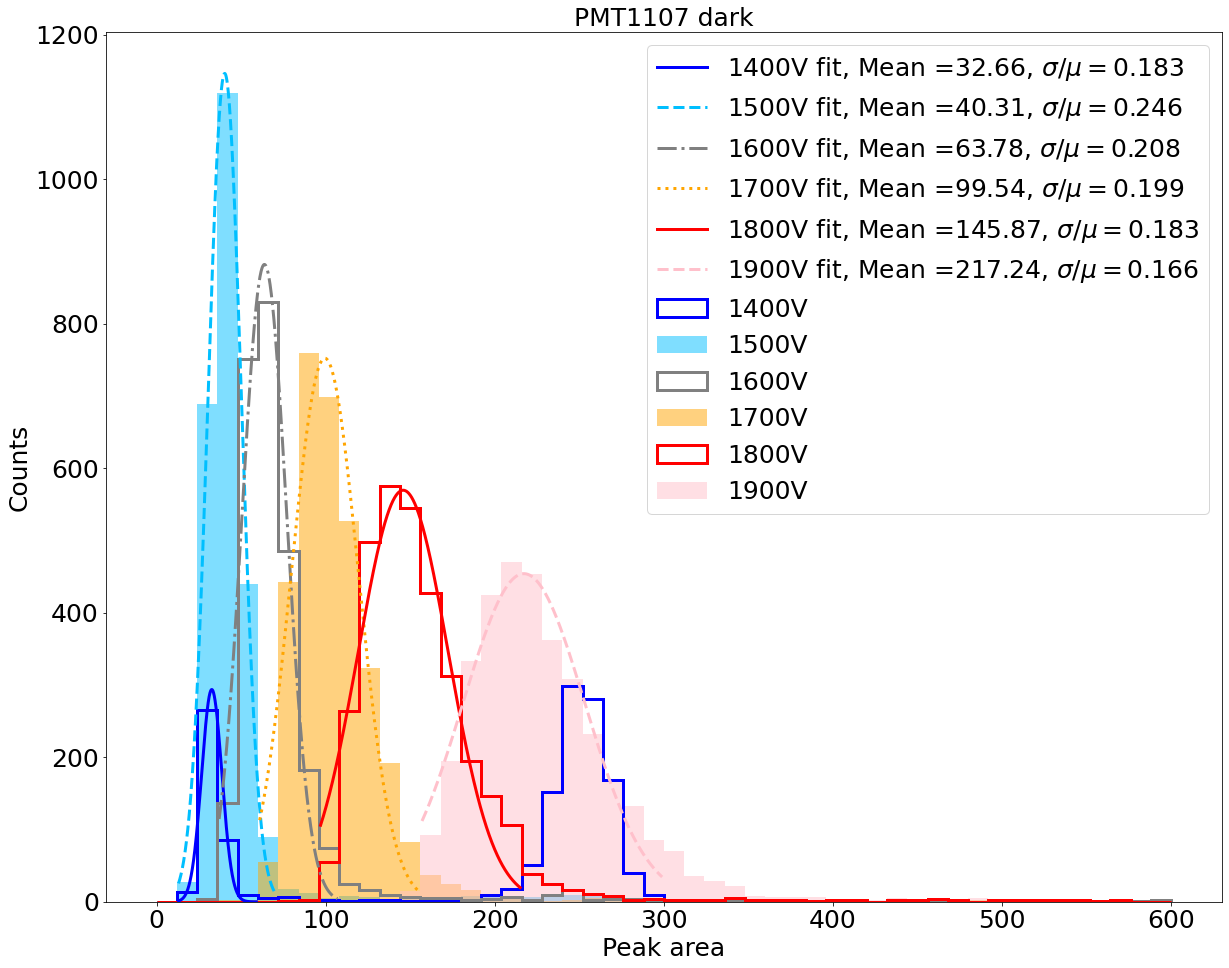

In [5]:
#draw fitting curve on histogram
plt.figure(figsize=(20, 16))
color_list = ['blue', 'deepskyblue', 'grey', 'orange', 'red', 'pink', 'green']
line_list = ['-', '--', '-.', ':', '-', '--', '-.']
histtype_list = ['step', 'bar', 'step', 'bar', 'step', 'bar', 'step']
alpha_list = [1, 0.5, 1, 0.5, 1, 0.5, 1]

for i in range(len(area)):
    if light_on:
        plt.hist(area[i], range=[0,range_lighton], bins=bins_lighton, label='{}V'.format(voltage_use[i]), histtype = histtype_list[i], alpha = alpha_list[i], linewidth=3, color=color_list[i]),
        plt.plot(np.linspace(100,range_lighton,1000), gaussian(np.linspace(150,range_lighton,1000), *popt[i]), label='{}V fit, Mean ='.format(voltage_use[i]) + str(round(popt[i][1], 2)), linestyle=line_list[i], linewidth=3, color=color_list[i]),
        plt.title('PMT%d light on'%PMT_num, fontsize=25)
    else:
        plt.hist(area[i], range=[0,range_dark], bins=bins_dark, label='{}V'.format(voltage_use[i]), histtype = histtype_list[i], alpha = alpha_list[i], linewidth=3, color=color_list[i]),
        plt.plot(np.linspace(start_value[i],end_value[i],1000), gaussian(np.linspace(start_value[i],end_value[i],1000), *popt[i]), label='{}V fit, Mean ='.format(voltage_use[i]) + str(round(popt[i][1], 2)) + ', $\sigma/\mu = $' + str(round(popt[i][2]/popt[i][1],3)), linestyle=line_list[i], linewidth=3, color=color_list[i]),
        plt.title('PMT%d dark'%PMT_num, fontsize=25)
plt.legend( fontsize=25)
plt.xlabel('Peak area', fontsize=25)
plt.ylabel('Counts', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#save figure
if light_on:
    plt.savefig('PMT%d_lighton_hist_fit.png'%PMT_num)
else:
    plt.savefig('PMT%d_dark_hist_fit.png'%PMT_num)


[32.6607626893943, 40.31217760829032, 63.78137522263401, 99.5388378824284, 145.8729624274643, 217.2430058712174]
[1400, 1500, 1600, 1700, 1800, 1900]


<Figure size 1440x864 with 0 Axes>

Text(0.5, 0, 'Voltage')

Text(0, 0.5, 'Mean of peak area')

Text(0.5, 1.0, 'Mean of peak area vs Voltage, dark')

(array([1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

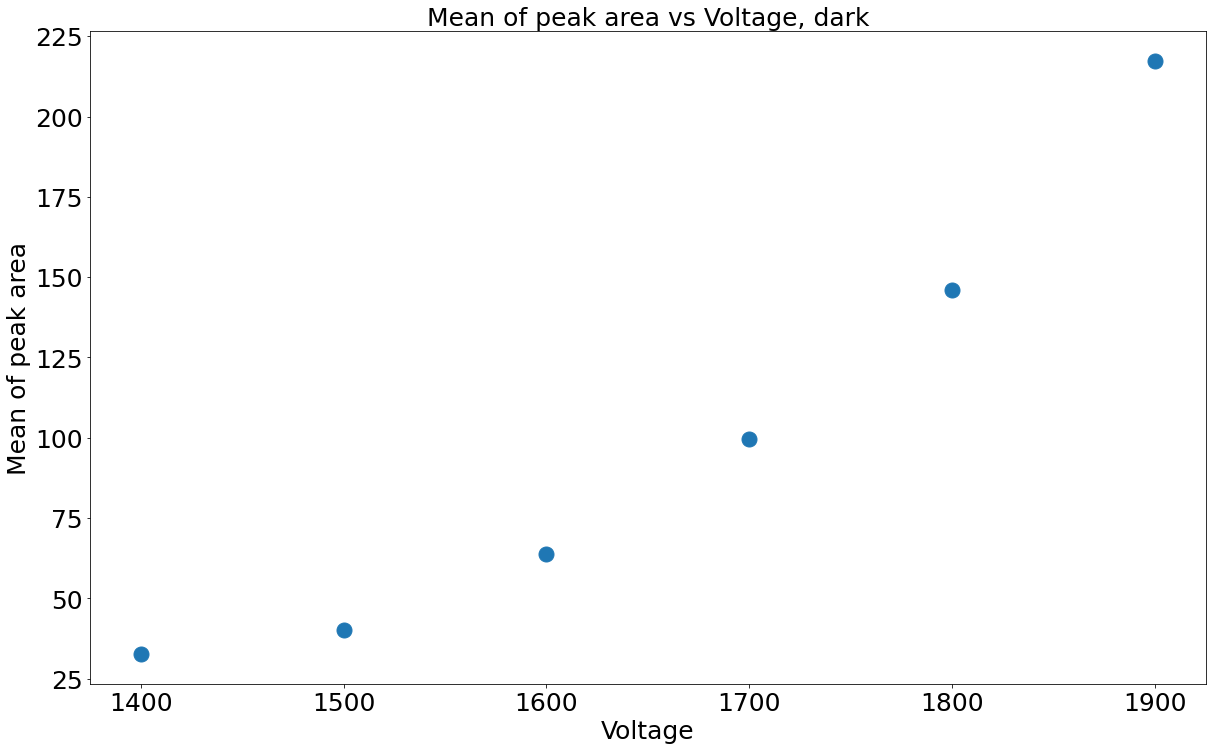

In [6]:
mean = []
for i in range(len(area)):
    mean.append(popt[i][1])
print(mean)
print(voltage_use)
plt.figure(figsize=(20, 12))
plt.plot(voltage_use, mean, 'o', markersize=15)
plt.xlabel('Voltage', fontsize=25)
plt.ylabel('Mean of peak area', fontsize=25)
if light_on:
    plt.title('Mean of peak area vs Voltage, ligh on', fontsize=25)
else:
    plt.title('Mean of peak area vs Voltage, dark', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

#save figure
if light_on:
    plt.savefig('PMT%d_lighton_mean_vs_voltage.png'%PMT_num)
else:
    plt.savefig('PMT%d_dark_mean_vs_voltage.png'%PMT_num)

popt= [2.60424643e+04 4.00980179e-03]
pcov= [[ 1.67152228e+07 -3.50717680e-01]
 [-3.50717680e-01  7.38476917e-09]]


<Figure size 1440x864 with 0 Axes>

Text(0.5, 0, 'Voltage')

Text(0, 0.5, 'Gain ($10^7$)')

Text(0.5, 1.0, 'PMT1107 Gain vs Voltage')

(array([1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000., 2100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([       0., 10000000., 20000000., 30000000., 40000000., 50000000.,
        60000000., 70000000., 80000000., 90000000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

37

76

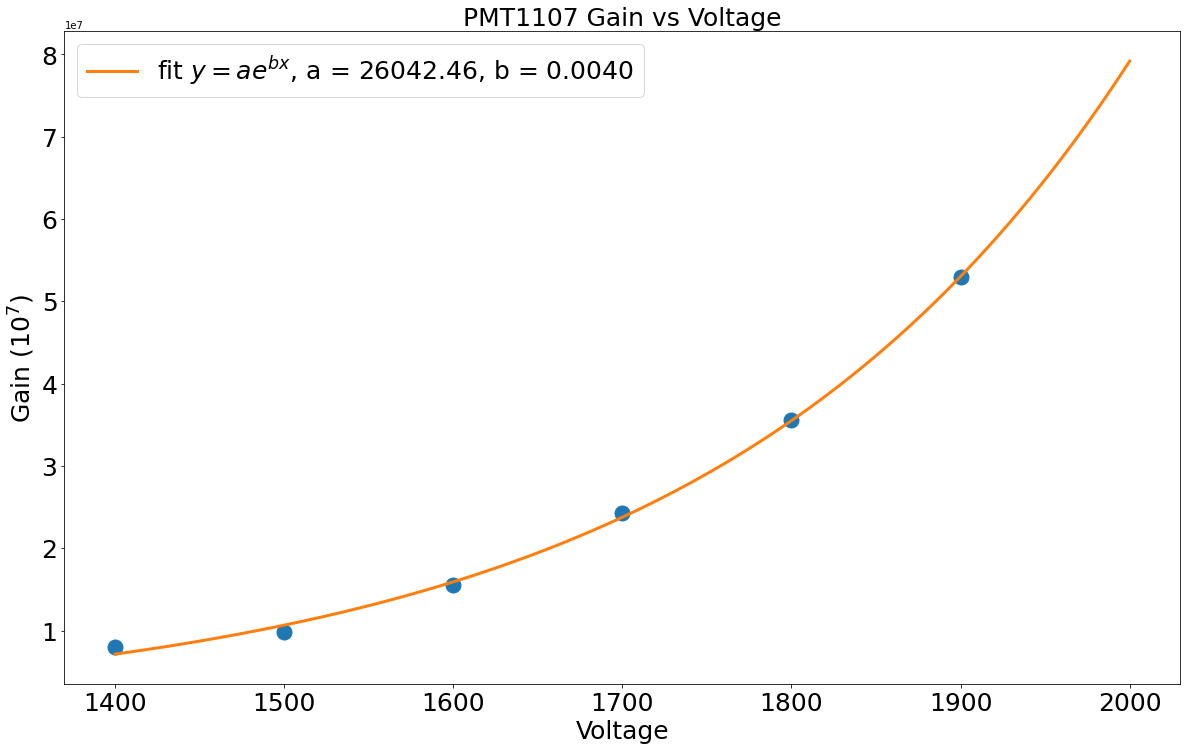

In [7]:
if light_on == 0:
    Gain_value = 243695.3808 * np.array(mean)
    #fit the gain with exponential function
    def exponential(x, a, b):
        return a* np.exp (b*np.array(x))

    popt, pcov = curve_fit(exponential, voltage_use, Gain_value, maxfev=100000, bounds=([1000, 0], [np.inf, 0.01]))
    print('popt=', popt)
    print('pcov=', pcov)
    plt.figure(figsize=(20, 12))
    plt.plot(voltage_use, Gain_value, 'o', markersize=15)
    x_fit = np.linspace(1400, 2000, 1000)
    plt.plot(x_fit, exponential(x_fit, *popt), label='fit $y=ae^{bx}$, a = %.2f, b = %.4f'%(popt[0], popt[1]), linewidth=3)
    plt.xlabel('Voltage', fontsize=25)
    plt.ylabel('Gain ($10^7$)', fontsize=25)
    plt.title('PMT%d Gain vs Voltage'%PMT_num, fontsize=25)
    plt.legend(fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    #save figure
    if light_on:
        plt.savefig('PMT%d_lighton_gain.png'%PMT_num)
    else:
        plt.savefig('PMT%d_dark_gain.png'%PMT_num)

    #save the fitting result to a txt file
    if light_on:
        f = open('PMT%d_lighton_gain_fit.txt'%PMT_num, 'w')
        f.write('popt={}\n'.format(popt))
        f.write('pcov={}\n'.format(pcov))
    else:
        f = open('PMT%d_dark_gain_fit.txt'%PMT_num, 'w')
        f.write('popt={}\n'.format(popt))
        f.write('pcov={}\n'.format(pcov))



[32.6607626893943, 40.31217760829032, 63.78137522263401, 99.5388378824284, 145.8729624274643, 217.2430058712174]
[5.962032746051076, 9.897529313471857, 13.254766388232847, 19.790957256901375, 26.648908908571155, 35.98257645866653]
[363.71551629926034, 603.1882561860115, 949.1431042462517, 1487.4541663592208, 2244.07427747268, 3266.115151894327]
[92.57425112693738, 140.73813105223456, 215.78502036977167, 343.2790295922904, 517.7070102471147, 783.165008988573]
[11.13616114 14.96292912 14.88119535 14.94345522 15.38375748 15.03438575]


<Figure size 1440x864 with 0 Axes>

<ErrorbarContainer object of 3 artists>

(0.0, 40.0)

Text(0.5, 0, 'Voltage')

Text(0, 0.5, 'Photoelectron number')

Text(0.5, 1.0, 'PMT1107 Photoelectron number vs Voltage')

(array([1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

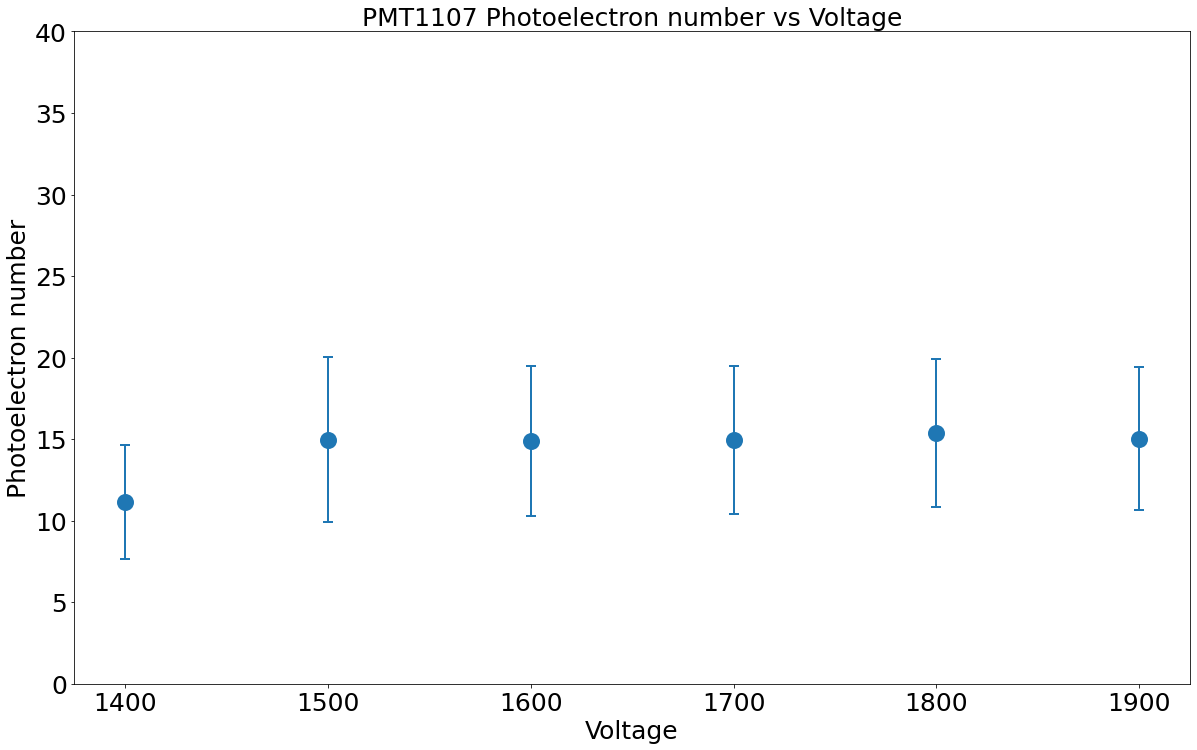

In [8]:
#plot the photon number vs voltage

#read the mean of dark peak area from txt file PMT%d_dark.txt
mean_dark = []
sigma_dark = []
try:
    f = open('PMT%d_dark.txt'%PMT_num, 'r')
    lines = f.readlines()
    for line in lines:
        if 'Mean of peak area for' in line:
            mean_dark.append(float(line.split(' ')[-1]))
        if 'Sigma of peak area for' in line:
            sigma_dark.append(float(line.split(' ')[-1]))
    print(mean_dark)
    print(sigma_dark)
except:
    print('No dark file')

#try to open the lighton file
mean_lighton = []
sigma_lighton = []
try:
    f = open('PMT%d_lighton.txt'%PMT_num, 'r')
    lines = f.readlines()
    for line in lines:
        if 'Mean of peak area' in line:
            mean_lighton.append(float(line.split(' ')[-1]))
        if 'Sigma of peak area' in line:
            sigma_lighton.append(float(line.split(' ')[-1]))
        
    print(mean_lighton)
    print(sigma_lighton)
except:
    print('No lighton file')

#calculate the photon number
if len(mean_dark) == len(mean_lighton):
    photon_number = np.array(mean_lighton)/np.array(mean_dark)
    print(photon_number)
    errorbar = photon_number * np.sqrt((np.array(sigma_lighton)/np.array(mean_lighton))**2 + (np.array(sigma_dark)/np.array(mean_dark))**2)
    plt.figure(figsize=(20, 12))
    # plt.plot(voltage_use, photon_number, 'o', markersize=15)
    plt.errorbar(voltage_use, photon_number, yerr=errorbar, fmt='o', markersize=15, capsize=5, elinewidth=2, markeredgewidth=2)
    plt.ylim(0, 40)
    plt.xlabel('Voltage', fontsize=25)
    plt.ylabel('Photoelectron number', fontsize=25)
    plt.title('PMT%d Photoelectron number vs Voltage'%PMT_num, fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    #save figure
    plt.savefig('PMT%d_Photoelectron_number.png'%PMT_num)
else:
    print('No lighton file or dark file')